# Restaurant Guide for Dubai

## Introduction

Dubai is one of the best tourist destinations around the world, best known for its shopping spots as well as for its magnificent attractions.

This project aims to provide with details regarding to what cuisines are available and their locations. 
A further analysis can be done to give the number of restaurants per area or cuisine or grouping based on both. 
It also provides with an analysis of the surrounding available ventures for each or any preferred restaurant.

## Data

For this project the data needed is:	
-	Dubai dataset containing list of restaurants and other venues along with its name, address, latitude, longitude taken from Kaggle. 
http://tour-pedia.org/download/dubai-restaurant.csv
-	Geopy to get latitudes and longitudes of each venue.
-	Foursquare API to get all venues in each area.

## Methodology

Lets first import all necessary libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

!pip install folium
import folium

import requests

%matplotlib inline

Now we read the dataset into a file

In [63]:
!wget -O dubai-restaurant.csv http://tour-pedia.org/download/dubai-restaurant.csv

--2020-08-31 16:40:54--  http://tour-pedia.org/download/dubai-restaurant.csv
Resolving tour-pedia.org (tour-pedia.org)... 146.48.98.235
Connecting to tour-pedia.org (tour-pedia.org)|146.48.98.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1760047 (1.7M) [text/csv]
Saving to: ‘dubai-restaurant.csv’

100%[======================================>] 1,760,047    670KB/s   in 2.6s   

2020-08-31 16:40:57 (670 KB/s) - ‘dubai-restaurant.csv’ saved [1760047/1760047]



In [64]:
df = pd.read_csv("dubai-restaurant.csv") 

In [65]:
df.head()

,address,category,id,lat,lng,location,name,originalId,polarity,subCategory,details,reviews
0,Sheikh Zayed Road,restaurant,114414,25.223014891762,55.285799503326,Dubai,Ibis - World Trade Centre Dubai,4b0587eaf964a5209ea622e3,0,Hotel,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
1,Jumeirah Beach Hotel,restaurant,114528,25.141867,55.190518,Dubai,Palm Court,4b0587edf964a5205aa722e3,0,Coffee Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
2,Near the Dubai Creek Golf and Yatch Club,restaurant,114560,25.243644,55.332521,Dubai,Cafe Arabesque,4b0587eef964a52098a722e3,0,Café,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
3,Opp Bur Juman,restaurant,114561,25.248801798183,55.313509366234,Dubai,Mirchi Indian Restaurant,4b0587eef964a5209aa722e3,0,Bar,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
4,"Al Qasr Hotel, Madinat Jumeirah",restaurant,114564,25.131259534087,55.184154510498,Dubai,Al Fayrooz Lounge,4b0587eef964a520a3a722e3,0,Coffee Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7342 entries, 0 to 7341
Data columns (total 12 columns):
address        5594 non-null object
category       7342 non-null object
id             7294 non-null object
lat            7342 non-null object
lng            7342 non-null object
location       7342 non-null object
name           7342 non-null object
originalId     7342 non-null object
polarity       7342 non-null object
subCategory    4354 non-null object
details        4354 non-null object
reviews        4354 non-null object
dtypes: object(12)
memory usage: 688.4+ KB


In [67]:
df.shape

(7342, 12)

Since generating a folium map for such a large dataset would not be possible we will slice it 

In [68]:
dfs = df[0:600]

Clean the data

In [69]:
df[~df.name.str.contains(r'\d')]
df = df[~df.name.str.contains(r'\d')]

In [70]:
df.shape

(4258, 12)

In [71]:
dfs[~dfs.name.str.contains(r'\d')]
dfs = dfs[~dfs.name.str.contains(r'\d')]
newdf = dfs[['name','address','location','subCategory','lat','lng','reviews']]

In [72]:
print("Shape :", newdf.shape)
newdf.head()

Shape : (568, 7)


,name,address,location,subCategory,lat,lng,reviews
0,Ibis - World Trade Centre Dubai,Sheikh Zayed Road,Dubai,Hotel,25.223014891762,55.285799503326,http://tour-pedia.org/api/getReviewsByPlaceId?...
1,Palm Court,Jumeirah Beach Hotel,Dubai,Coffee Shop,25.141867,55.190518,http://tour-pedia.org/api/getReviewsByPlaceId?...
2,Cafe Arabesque,Near the Dubai Creek Golf and Yatch Club,Dubai,Café,25.243644,55.332521,http://tour-pedia.org/api/getReviewsByPlaceId?...
3,Mirchi Indian Restaurant,Opp Bur Juman,Dubai,Bar,25.248801798183,55.313509366234,http://tour-pedia.org/api/getReviewsByPlaceId?...
4,Al Fayrooz Lounge,"Al Qasr Hotel, Madinat Jumeirah",Dubai,Coffee Shop,25.131259534087,55.184154510498,http://tour-pedia.org/api/getReviewsByPlaceId?...


Get coordinates of Dubai using geopy

In [73]:
address = 'Dubai, UAE'

geo_locator = Nominatim(user_agent = 'ny_explorer')
location = geo_locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Dubai are {}, {}.'.format(latitude, longitude))

The coordinates of Dubai are 25.0750095, 55.18876088183319.


Generate a map with clusters using K-Means

In [74]:
dubai_map = folium.Map(location=[latitude, longitude], zoom_start=10)

lt = newdf['lat']
lg = newdf['lng']
s = np.stack((lt,lg), axis=1)

kmeans = KMeans(n_clusters=5 ,random_state=0).fit(s)

clusters = kmeans.labels_colors =['red','green','blue','yellow','orange']


for lat, lng, location, name in zip(newdf['lat'], newdf['lng'], newdf['location'], newdf['name']):
    label = '{}, {}'.format(name, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([float(lat),float(lng)],
                        tiles = 'Stamen Toner',
                        popup = label,
                        fill = True,
                        color = 'blue',
                        fill_color = '#FFFFFF',
                        fill_opacity = 0.8, 
                        radius = 5
                       ).add_to(dubai_map)  
    
dubai_map

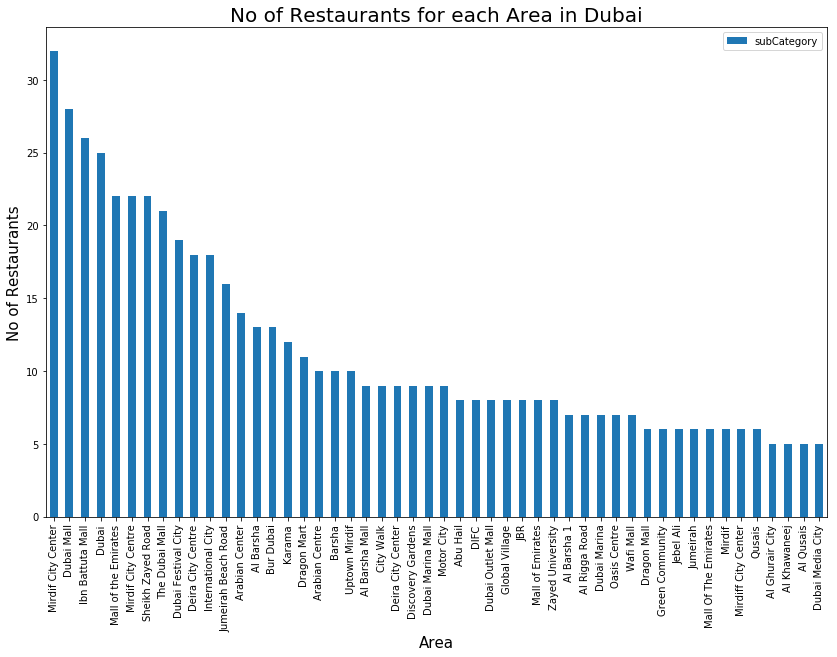

In [75]:
plt.figure(figsize=(14,9))

clust = df.groupby('address')['subCategory'].count().nlargest(50).plot.bar()

plt.title ("No of Restaurants for each Area in Dubai", fontsize = 20)
plt.xlabel("Area", fontsize = 15)
plt.ylabel("No of Restaurants", fontsize = 15)
plt.legend()
plt.show()

From the above cluster map and bar graph we can see that Mirdif City Center (MCC) is the area with the highest number of restaurants.

In [76]:
mcc_df = df[df['address'] == 'Mirdif City Center']
print(mcc_df.shape)
mcc_df

(32, 12)


,address,category,id,lat,lng,location,name,originalId,polarity,subCategory,details,reviews
253,Mirdif City Center,restaurant,115259,25.214725766164,55.407357215881,Dubai,Caffe' NERO كافيه نيرو,4bacaf2ef964a52099033be3,0,Café,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
272,Mirdif City Center,restaurant,115317,25.21275071504,55.412709282748,Dubai,Marble Slab,4bb986e5cf2fc9b62a9da002,0,Ice Cream Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
339,Mirdif City Center,restaurant,115504,25.160166850722,55.409260239051,Dubai,Mango Tree,4bd072b4a8b3a593c3d9635f,0,Thai Restaurant,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
383,Mirdif City Center,restaurant,115658,25.214305594185,55.388444540159,Dubai,Chili's,4be538bcd4f7c9b67c2b2520,0,Eastern European Restaurant,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
404,Mirdif City Center,restaurant,115709,25.215748943292,55.408795331383,Dubai,Caribou Coffee | مقهى كاريبو,4bed638d91380f4790cb9f18,0,Coffee Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
414,Mirdif City Center,restaurant,115730,25.215657593001,55.407485961914,Dubai,Costa @ Mirdif City Center,4bf11497a09076b080cc29d4,0,Coffee Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
473,Mirdif City Center,restaurant,115855,25.216045852077,55.408515930176,Dubai,Pinkberry,4c08e196ffb8c9b6e0e06861,0,Frozen Yogurt,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
605,Mirdif City Center,restaurant,116183,25.217745979378,55.408168250554,Dubai,Sugar Daddy's,4c557700479fc928d7fbde94,0,Cupcake Shop,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
708,Mirdif City Center,restaurant,116467,25.253131205621,55.417201893998,Dubai,Zafran,4c9ddc18542b224b22f1ed9f,0,Indian Restaurant,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...
804,Mirdif City Center,restaurant,116722,25.217832630232,55.408189873956,Dubai,Sukiyaki,4ccef172063a721e3e0e9d9a,0,Japanese Restaurant,http://tour-pedia.org/api/getPlaceDetails?id=1...,http://tour-pedia.org/api/getReviewsByPlaceId?...


In [77]:
mcc_df = mcc_df[['name','address','location','subCategory','lat','lng','reviews']]
print(mcc_df.shape)
mcc_df

(32, 7)


,name,address,location,subCategory,lat,lng,reviews
253,Caffe' NERO كافيه نيرو,Mirdif City Center,Dubai,Café,25.214725766164,55.407357215881,http://tour-pedia.org/api/getReviewsByPlaceId?...
272,Marble Slab,Mirdif City Center,Dubai,Ice Cream Shop,25.21275071504,55.412709282748,http://tour-pedia.org/api/getReviewsByPlaceId?...
339,Mango Tree,Mirdif City Center,Dubai,Thai Restaurant,25.160166850722,55.409260239051,http://tour-pedia.org/api/getReviewsByPlaceId?...
383,Chili's,Mirdif City Center,Dubai,Eastern European Restaurant,25.214305594185,55.388444540159,http://tour-pedia.org/api/getReviewsByPlaceId?...
404,Caribou Coffee | مقهى كاريبو,Mirdif City Center,Dubai,Coffee Shop,25.215748943292,55.408795331383,http://tour-pedia.org/api/getReviewsByPlaceId?...
414,Costa @ Mirdif City Center,Mirdif City Center,Dubai,Coffee Shop,25.215657593001,55.407485961914,http://tour-pedia.org/api/getReviewsByPlaceId?...
473,Pinkberry,Mirdif City Center,Dubai,Frozen Yogurt,25.216045852077,55.408515930176,http://tour-pedia.org/api/getReviewsByPlaceId?...
605,Sugar Daddy's,Mirdif City Center,Dubai,Cupcake Shop,25.217745979378,55.408168250554,http://tour-pedia.org/api/getReviewsByPlaceId?...
708,Zafran,Mirdif City Center,Dubai,Indian Restaurant,25.253131205621,55.417201893998,http://tour-pedia.org/api/getReviewsByPlaceId?...
804,Sukiyaki,Mirdif City Center,Dubai,Japanese Restaurant,25.217832630232,55.408189873956,http://tour-pedia.org/api/getReviewsByPlaceId?...


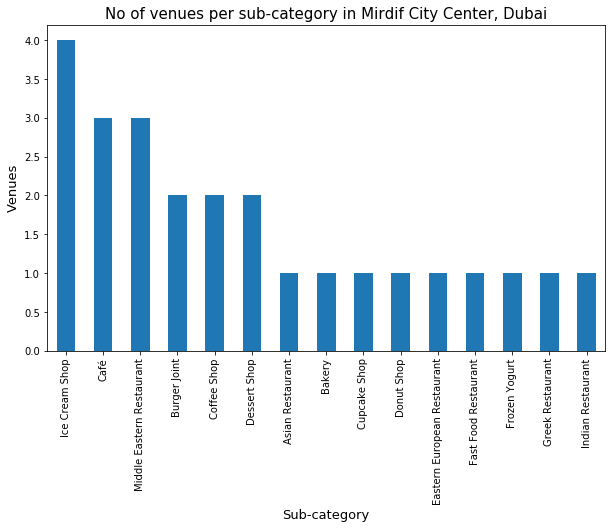

In [78]:
plt.figure(figsize=(10,6))

samplt = mcc_df.groupby('subCategory')['address'].count().nlargest(15).plot.bar()

plt.title ("No of venues per sub-category in Mirdif City Center, Dubai", fontsize = 15)
plt.xlabel("Sub-category", fontsize = 13)
plt.ylabel("Venues", fontsize = 13)
plt.show()

Now generate a map depicting the distribution of venues in Mirdif City Center

In [79]:
address = 'Mirdif City Center'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Mirdif City Center are {}, {}.'.format(latitude, longitude))

The coordinates of Mirdif City Center are 25.21598125, 55.40746704313602.


In [80]:
mcc_map = folium.Map(location = [25.21598125, 55.40746704313602], zoom_start=20)

lt = newdf['lat']
lg = newdf['lng']
s = np.stack((lt,lg), axis=1)

kmeans = KMeans(n_clusters = 5 ,random_state = 0).fit(s)

clusters = kmeans.labels_colors = ['red', 'blue', 'yellow', 'green', 'orange']


for lat, lng, location,name in zip(newdf['lat'], newdf['lng'], newdf['location'],newdf['name']):
    label = '{}, {}'.format(name, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([float(lat),float(lng)],
                        tiles = 'Stamen Toner',
                        popup = label,
                        fill = True,
                        color = 'blue',
                        fill_color = '#FFFFFF',
                        fill_opacity = 0.8, 
                        radius = 5
                       ).add_to(mcc_map)  


mcc_map

Now to analyse the venues surrounding the restaurant in Mirdif City Center

In [81]:
def get_surr_venue(names, latitudes, longitudes, radius=500):
    
    venues = []
    
    client_id = 'FRKTXSQ42ICGKQC52M2PQ4K5W0YXVMAAOOIBVTXFTEDLWNAF'
    client_secret = '0U15WN2TX5IVGPILDDJQRCT1EDVVYTGVCKOAWV12RGO0IBXD'
    version = '20200931'
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            )
            
            
        result = requests.get(url).json()["response"]['groups'][0]['items']
        
        for v in result:
            venues.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'])])

    surr_venue = pd.DataFrame([item for vlist in venues for item in vlist])
    surr_venue.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(surr_venue)

In [82]:
mcc_venues = get_surr_venue(names = mcc_df['name'],
                            latitudes = mcc_df['lat'],
                            longitudes = mcc_df['lng']
                           )

Caffe' NERO كافيه نيرو
Marble Slab
Mango Tree
Chili's
Caribou Coffee | مقهى كاريبو
Costa @ Mirdif City Center
Pinkberry
Sugar Daddy's
Zafran
Sukiyaki
Cold Stone Creamery
Paul Cafe
Pars
Jimmy The Greek
Haagen Dazs هاجن داز
GBK
Chocolate Bar شوكلت بار
Love Life Boost
McDonald's
Pars Restuarant مطعم بارس
edo - japanese mochi
Leila ليلى
Chinese Palace Restaurant
Krispy Kreme
Abdelwahab عبدالوهاب
Arabesq - أرابيسك
daily fresh
Papa John's Pizza
Max Burger | ماكس برغر
Rosa Mexicano روزا مكسيكانو
Pappa Roti
Pinkberry


In [83]:
mcc_venues.shape

(835, 7)

In [84]:
mcc_venues.groupby('Venue').count()
print('No of uniques categories : {}'.format(len(mcc_venues['Venue Category'].unique())))

No of uniques categories : 57


In [85]:
mcc_venues.head()

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Caffe' NERO كافيه نيرو,25.214725766164,55.407357215881,VOX Cinemas (ڤوكس سينما),25.214773,55.407198,Multiplex
1,Caffe' NERO كافيه نيرو,25.214725766164,55.407357215881,Texas Roadhouse,25.216154,55.408341,Steakhouse
2,Caffe' NERO كافيه نيرو,25.214725766164,55.407357215881,P.F. Chang's (بي إف تشانغز),25.216313,55.408616,Chinese Restaurant
3,Caffe' NERO كافيه نيرو,25.214725766164,55.407357215881,Yalla Bowling Lanes,25.214716,55.408882,Bowling Alley
4,Caffe' NERO كافيه نيرو,25.214725766164,55.407357215881,VOX GOLD,25.214771,55.406673,Movie Theater


In [86]:
mcc_one_hot = pd.get_dummies(mcc_venues[['Venue Category']], prefix="", prefix_sep="")

mcc_one_hot['Area'] = mcc_venues['Area'] 

fix_col = [mcc_one_hot.columns[-1]] + list(mcc_one_hot.columns[:-1])
mcc_one_hot = mcc_one_hot[fix_col]

In [87]:
mcc_one_hot.shape

(835, 58)

In [88]:
mcc_group = mcc_one_hot.groupby('Area').mean().reset_index()
mcc_group

,Area,Accessories Store,Airport,American Restaurant,Arcade,Asian Restaurant,Badminton Court,Bakery,Beach,Big Box Store,...,Shoe Store,Shopping Mall,Snack Place,Spa,Sporting Goods Shop,Sri Lankan Restaurant,Steakhouse,Supermarket,Tex-Mex Restaurant,Theme Park Ride / Attraction
0,Abdelwahab عبدالوهاب,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333
1,Arabesq - أرابيسك,0.000,0.000,0.033333,0.000000,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000
2,Caffe' NERO كافيه نيرو,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333
3,Caribou Coffee | مقهى كاريبو,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333
4,Chili's,0.125,0.125,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Chinese Palace Restaurant,0.000,0.000,0.033333,0.000000,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333
6,Chocolate Bar شوكلت بار,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333
7,Cold Stone Creamery,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333
8,Costa @ Mirdif City Center,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333
9,GBK,0.000,0.000,0.033333,0.033333,0.000000,0.000,0.033333,0.000000,0.000000,...,0.00000,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333


In [89]:
topf_venues = 5

for a in mcc_group['Area']:
    print(a)
    temp = mcc_group[mcc_group['Area'] == a].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(topf_venues))
    print('\n')

    
def common_venues(row, topf_venues):
    ctg = row.iloc[1:]
    sort_ctg = ctg.sort_values(ascending=False)
    
    return sort_ctg.index.values[0:topf_venues]

Abdelwahab عبدالوهاب
                          venue  freq
0                   Coffee Shop  0.13
1                 Movie Theater  0.10
2  Theme Park Ride / Attraction  0.03
3            Chinese Restaurant  0.03
4           Lebanese Restaurant  0.03


Arabesq - أرابيسك
                venue  freq
0         Coffee Shop  0.10
1       Movie Theater  0.07
2      Clothing Store  0.07
3  Chinese Restaurant  0.03
4          Restaurant  0.03


Caffe' NERO كافيه نيرو
                          venue  freq
0                   Coffee Shop  0.13
1                 Movie Theater  0.10
2  Theme Park Ride / Attraction  0.03
3            Chinese Restaurant  0.03
4           Lebanese Restaurant  0.03


Caribou Coffee | مقهى كاريبو
                          venue  freq
0                   Coffee Shop  0.13
1                 Movie Theater  0.10
2  Theme Park Ride / Attraction  0.03
3            Chinese Restaurant  0.03
4           Lebanese Restaurant  0.03


Chili's
                    venue  freq
0       A

In [90]:
top_venues = 10

indicator = ['st', 'nd', 'rd']

columns = ['Area']
for i in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicator[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

        
sort_venue = pd.DataFrame(columns=columns)
sort_venue['Area'] = mcc_group['Area']

for i in np.arange(mcc_group.shape[0]):
    sort_venue.iloc[i, 1:] = common_venues(mcc_group.iloc[i, :], top_venues)

sort_venue

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abdelwahab عبدالوهاب,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bookstore,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Indian Restaurant
1,Arabesq - أرابيسك,Coffee Shop,Movie Theater,Clothing Store,Restaurant,Record Shop,Chinese Restaurant,Lebanese Restaurant,Café,Burger Joint,Multiplex
2,Caffe' NERO كافيه نيرو,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bakery,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Chinese Restaurant
3,Caribou Coffee | مقهى كاريبو,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bakery,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Chinese Restaurant,Indian Restaurant
4,Chili's,Accessories Store,Badminton Court,Hotel,Furniture / Home Store,Department Store,Sandwich Place,Burger Joint,Airport,Bakery,Beach
5,Chinese Palace Restaurant,Coffee Shop,Indian Restaurant,Movie Theater,Theme Park Ride / Attraction,Burger Joint,Frozen Yogurt Shop,Furniture / Home Store,Gift Shop,Gym,Cosmetics Shop
6,Chocolate Bar شوكلت بار,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bakery,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Chinese Restaurant
7,Cold Stone Creamery,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bookstore,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Indian Restaurant
8,Costa @ Mirdif City Center,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bakery,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Chinese Restaurant
9,GBK,Coffee Shop,Movie Theater,Theme Park Ride / Attraction,Bakery,Gift Shop,Gym,Cosmetics Shop,Clothing Store,Ice Cream Shop,Chinese Restaurant


## Results

From this we can see that:
1.	Mirdif City Center has the greatest number of restaurants.
2.	Ice cream shops have potential in Mirdif City Center area.
3.	The area of Abdelwahab is quite popular and has a high frequency of surrounding venues.
4.	Japanese cuisine in not as available and has low frequency of surrounding venues.